# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import os
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3"
os.environ["JAVA_HOME"]="/Library/java/JavaVirtualMachines/adoptopenjdk-8.jdk/contents/Home/"

In [2]:
import findspark
findspark.init()

In [121]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
import datetime

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, MinMaxScaler, VectorAssembler 
from sklearn.metrics import classification_report,confusion_matrix
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# Read in sparkify dataset
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# number of records
df.count()

286500

In [8]:
# check number of missing values in each column
missing_values = [F.count(F.when(F.col(c).isNull(), c)).alias(c)
                  for c in df.columns]
df.select(missing_values).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [9]:
df.select("auth").dropDuplicates().sort("userId").show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
| Cancelled|
| Logged In|
+----------+



In [10]:
df.select("userId").dropDuplicates().sort("userId").show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [11]:
# drop missing values for userId and sessionId
df_valid = df.dropna(how="any", subset=["userId", "sessionId"])

In [12]:
# filter out empty userId's
df_valid = df_valid.filter(df['userId'] != "")

In [13]:
# fill missing values of length with 0
df_valid = df_valid.na.fill(0, subset=['length'])

In [14]:
# check number of missing values in each column again
missing_values = [F.count(F.when(F.col(c).isNull(), c)).alias(c)
                  for c in df_valid.columns]
df_valid.select(missing_values).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [15]:
df_valid.filter(F.col('artist').isNull()).select(
    'page').dropDuplicates().show(20, False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [16]:
df_valid.filter(F.col('artist').isNotNull()).select(
    'page').dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [17]:
# number of users
df.filter(df['userId']!='').select("userId").dropDuplicates().count()

225

In [18]:
# number of artists
df.select("artist").dropDuplicates().count()

17656

In [19]:
# auth
df.select("auth").dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [20]:
# itemInSession
df.select("itemInSession").describe().show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201141085|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [21]:
# length
df.select("length").describe().show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783722|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fca362ad850>]],
      dtype=object)

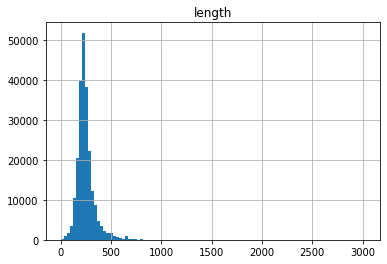

In [22]:
# histogram for length
df.select("length").toPandas().hist(bins=100)

In [23]:
# level
df.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [24]:
# location
df.select("location").dropDuplicates().show(20, False)

+---------------------------------------+
|location                               |
+---------------------------------------+
|Gainesville, FL                        |
|Atlantic City-Hammonton, NJ            |
|Deltona-Daytona Beach-Ormond Beach, FL |
|San Diego-Carlsbad, CA                 |
|Cleveland-Elyria, OH                   |
|Kingsport-Bristol-Bristol, TN-VA       |
|New Haven-Milford, CT                  |
|Birmingham-Hoover, AL                  |
|Corpus Christi, TX                     |
|Dubuque, IA                            |
|Las Vegas-Henderson-Paradise, NV       |
|Indianapolis-Carmel-Anderson, IN       |
|Seattle-Tacoma-Bellevue, WA            |
|Albany, OR                             |
|Winston-Salem, NC                      |
|Bakersfield, CA                        |
|Los Angeles-Long Beach-Anaheim, CA     |
|Minneapolis-St. Paul-Bloomington, MN-WI|
|San Francisco-Oakland-Hayward, CA      |
|Phoenix-Mesa-Scottsdale, AZ            |
+---------------------------------

In [25]:
# method
df.select("method").dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [26]:
# page
df.select("page").dropDuplicates().show(22, False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [27]:
# registration
df.select("registration").show(5)

+-------------+
| registration|
+-------------+
|1538173362000|
|1538331630000|
|1538173362000|
|1538331630000|
|1538173362000|
+-------------+
only showing top 5 rows



In [28]:
# songs
df.select("song").show(5, False)

+-----------------------------+
|song                         |
+-----------------------------+
|Rockpools                    |
|Canada                       |
|Time For Miracles            |
|Knocking On Forbidden Doors  |
|Harder Better Faster Stronger|
+-----------------------------+
only showing top 5 rows



In [29]:
# number of songs
df.select("song").drop_duplicates().count()

58481

In [30]:
# status
df.select("status").drop_duplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [31]:
# ts
df.select("ts").show(5)

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
+-------------+
only showing top 5 rows



In [32]:
# userAgent
df_valid.select("userAgent").drop_duplicates().show(10, False)

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"|


## Define Churn

Define churn events as`Cancellation Confirmation` events or `Submit Downgrade` events.
Create a column `churn_user` to use as the label for the model. 

In [33]:
# define churn event
flag_churn_event = F.udf(lambda x: 1 if (
    x == 'Cancellation Confirmation') else 0, T.IntegerType())

In [34]:
# create churn event column
df_valid = df_valid.withColumn('churn_event', flag_churn_event('page'))

In [35]:
# create churn user column
df_valid = df_valid.withColumn('churn_user', F.max(
    'churn_event').over(Window.partitionBy('userId')))

## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [36]:
# number of users
num_users = df_valid.select(F.countDistinct('userId')).collect()[0][0]
print("number of users:", num_users)

number of users: 225


In [37]:
# number of churn_events
df_valid.select(F.sum('churn_event')).show()

+----------------+
|sum(churn_event)|
+----------------+
|              52|
+----------------+



In [38]:
# number of churn and not churn users
num_churn_users = df_valid.filter(df_valid['churn_user'] == '1').select(
    F.countDistinct('userId')).collect()[0][0]
num_not_churn_users = num_users - num_churn_users
print("number of churn users:", num_churn_users)
print("number of not churn users:", num_not_churn_users)

number of churn users: 52
number of not churn users: 173


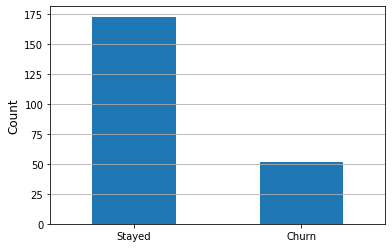

In [39]:
d = {'churns': [num_not_churn_users, num_churn_users]}
df_churns = pd.DataFrame(data=d, index=['Stayed', 'Churn'])
ax = df_churns.plot.bar(legend=False)
ax.grid(axis='y')
ax.set_ylabel('Count', fontsize=12)
plt.xticks(rotation=0);

### Gender

In [40]:
num_females = df_valid.filter(df_valid['gender'] == 'F').select(
    F.countDistinct('userId')).collect()[0][0]
num_males = num_users - num_females
print("number of females:", num_females)
print("number of males:", num_males)

number of females: 104
number of males: 121


In [41]:
df_gender = df_valid.groupby('gender').sum('churn_event').toPandas()
df_gender['count'] = [num_females, num_males]
df_gender['percent churn'] = df_gender['sum(churn_event)'] / \
    df_gender['count']*100
df_gender.columns = ['gender', 'num_churns', 'count', 'percent churn']
df_gender.set_index('gender')

,num_churns,count,percent churn
gender,,,
F,20,104,19.230769
M,32,121,26.446281


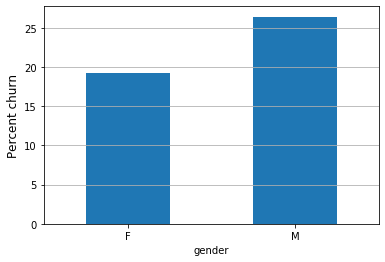

In [42]:
ax = df_gender.plot.bar(x='gender', y='percent churn', legend=False)
ax.grid(axis='y')
ax.set_ylabel('Percent churn', fontsize=12)
plt.xticks(rotation=0);

### Level

In [43]:
num_free = df_valid.filter(df_valid['level'] == 'free').select(
    F.countDistinct('userId')).collect()[0][0]
num_paid = df_valid.filter(df_valid['level'] == 'paid').select(
    F.countDistinct('userId')).collect()[0][0]

In [44]:
df_level = df_valid.groupby('level').sum('churn_event').toPandas()
df_level['count'] = [num_free, num_paid]
df_level['percent churn'] = df_level['sum(churn_event)'] / \
    df_level['count'] * 100
df_level.columns = ['level', 'num_churns', 'count', 'percent churn']
df_level.set_index('level')

,num_churns,count,percent churn
level,,,
free,21,195,10.769231
paid,31,165,18.787879


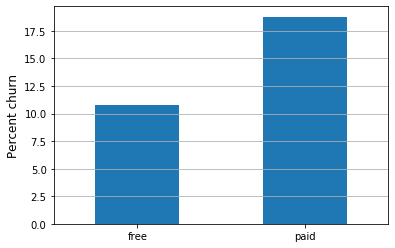

In [45]:
ax = df_level.plot.bar(x='level', y='percent churn', legend=False)
ax.grid(axis='y')
ax.set_ylabel('Percent churn', fontsize=12)
ax.set_xlabel('')
plt.xticks(rotation=0);

### Location

In [46]:
df_valid.select("location").show(10, False)

+------------------------------+
|location                      |
+------------------------------+
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Bakersfield, CA               |
|Bakersfield, CA               |
+------------------------------+
only showing top 10 rows



In [47]:
get_state = F.udf(lambda x: x[-2:])

In [48]:
# create state column
df_valid = df_valid.withColumn("state", get_state(df_valid['location']))

In [49]:
df_state_counts = df_valid.select(
    'userId', 'state').dropDuplicates().groupby('state').count().toPandas()

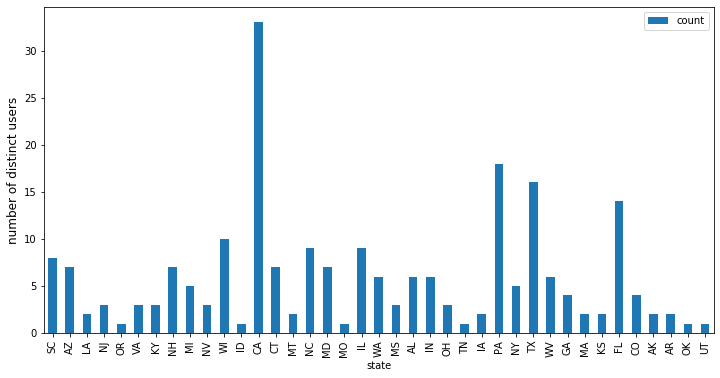

In [50]:
ax = df_state_counts.plot.bar(x='state', y='count',
                              figsize=(12, 6))
ax.set_ylabel('number of distinct users', fontsize=12);

In [51]:
df_state_churns = df_valid.groupby('state').sum('churn_event').toPandas()
df_state_churns.columns = ['state', 'num_churns']

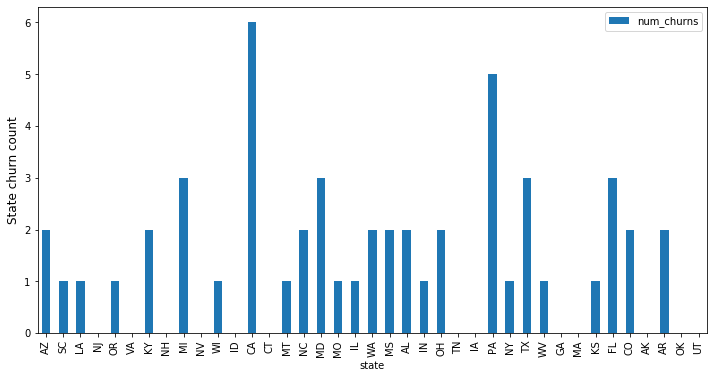

In [52]:
ax = df_state_churns.plot.bar(x='state', y='num_churns', figsize=(12, 6))
ax.set_ylabel('State churn count', fontsize=12);

In [53]:
df_state_churns['percent churn'] = df_state_churns['num_churns'] / \
    df_state_counts['count'] * 100

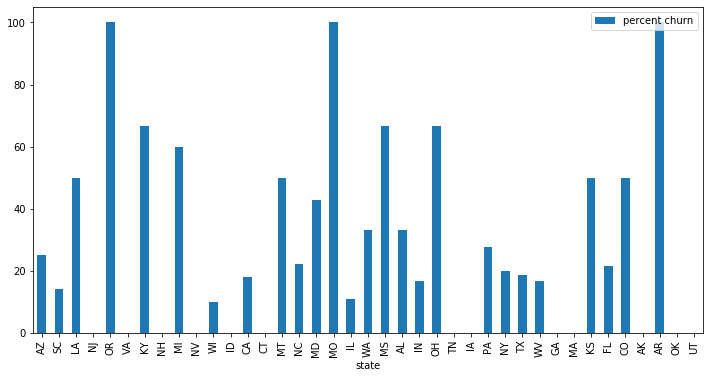

In [54]:
df_state_churns.plot.bar(x='state', y='percent churn', figsize=(12, 6));

### Registration

In [55]:
# create datetime columns for registration and timestamp
df_valid = df_valid.withColumn(
    'registration_dt', (F.col('registration')/1000).cast(T.TimestampType()))
df_valid = df_valid.withColumn(
    'dt', (F.col('ts')/1000).cast(T.TimestampType()))

In [56]:
# find earliest and latest registration dates
start_reg_date = df_valid.agg({'registration_dt': 'min'}).collect()
end_reg_date = df_valid.agg({'registration_dt': 'max'}).collect()
print('registration start date:', str(start_reg_date[0][0]))
print('registration end date:', str(end_reg_date[0][0]))

registration start date: 2018-03-18 08:44:35
registration end date: 2018-11-26 09:49:14


In [57]:
# find earliest and latest dates (from timestamp)
start_date = df_valid.agg({'dt': 'min'}).collect()
end_date = df_valid.agg({'dt': 'max'}).collect()
print('start date:', str(start_date[0][0]))
print('end date:', str(end_date[0][0]))

start date: 2018-09-30 19:01:57
end date: 2018-12-02 19:11:16


In [58]:
# number of days since registration
df_valid = df_valid.withColumn(
    "days_since_reg", F.max(F.datediff('dt', 'registration_dt')).over(Window.partitionBy('userId')))

In [59]:
df_valid.select('days_since_reg').describe().show()

+-------+-----------------+
|summary|   days_since_reg|
+-------+-----------------+
|  count|           278154|
|   mean|88.91284684023958|
| stddev| 40.4933547852528|
|    min|                0|
|    max|              256|
+-------+-----------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fca37160410>]],
      dtype=object)

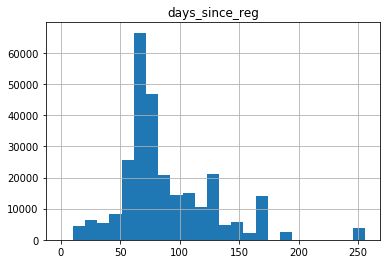

In [60]:
df_valid.select('days_since_reg').toPandas().hist(bins=25)

In [61]:
df_days_stayed = df_valid.filter(
    df_valid['churn_user'] == 0).select('days_since_reg').toPandas()
df_days_churn = df_valid.filter(
    df_valid['churn_user'] == 1).select('days_since_reg').toPandas()

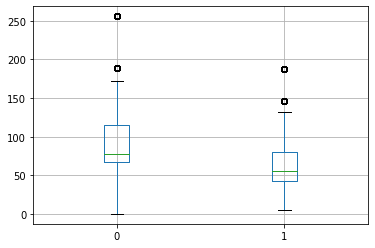

In [62]:
pd.concat([df_days_stayed, df_days_churn], axis=1, ignore_index=True).boxplot()

In [63]:
df_valid.groupby('churn_user').mean('days_since_reg').show()

+----------+-------------------+
|churn_user|avg(days_since_reg)|
+----------+-------------------+
|         1|  67.66108684022825|
|         0|  92.99977281495134|
+----------+-------------------+



### Weekly churn events

In [64]:
def resample(column, agg_interval=900, time_format='yyyy-MM-dd HH:mm:ss'):
    if type(column)==str:
        column = F.col(column)

    # Convert the timestamp to unix timestamp format.
    # Unix timestamp = number of seconds since 00:00:00 UTC, 1 January 1970.
    col_ut =  F.unix_timestamp(column, format=time_format)

    # Divide the time into dicrete intervals, by rounding. 
    col_ut_agg =  F.floor(col_ut / agg_interval) * agg_interval  

    # Convert to and return a human readable timestamp
    return F.from_unixtime(col_ut_agg)

In [65]:
# resampled for weekly intervals
df_valid = df_valid.withColumn('dt_resampled', resample(df_valid.dt, agg_interval=604800))
df_valid.select('dt', 'dt_resampled', 'churn_event').show(5)

+-------------------+-------------------+-----------+
|                 dt|       dt_resampled|churn_event|
+-------------------+-------------------+-----------+
|2018-09-30 19:01:57|2018-09-26 19:00:00|          0|
|2018-09-30 19:03:00|2018-09-26 19:00:00|          0|
|2018-09-30 19:06:34|2018-09-26 19:00:00|          0|
|2018-09-30 19:06:56|2018-09-26 19:00:00|          0|
|2018-09-30 19:11:16|2018-09-26 19:00:00|          0|
+-------------------+-------------------+-----------+
only showing top 5 rows



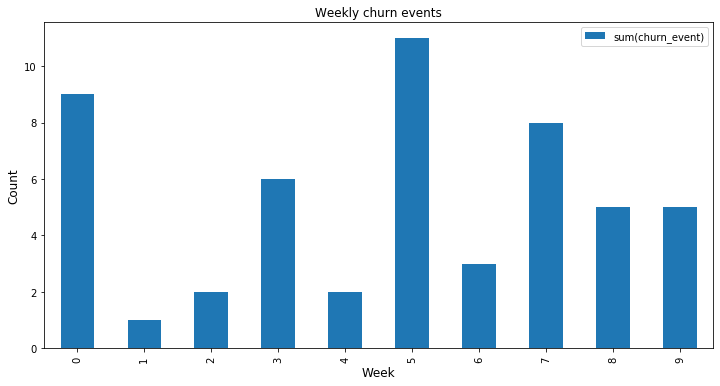

In [66]:
ax = df_valid.groupBy('dt_resampled').sum('churn_event').toPandas().plot.bar(figsize=(12,6))
ax.set_xlabel('Week', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Weekly churn events');

### Song

In [67]:
# time window to find number of songs played in a day
def days(x): return x * 86400


windowval = (
    Window.partitionBy("userId")
    .orderBy(F.col("ts")/1000)
    .rangeBetween(-days(1), 0)
)

In [68]:
# number of songs played in a day
df_valid = df_valid.withColumn("num_songs", F.count("song").over(windowval))

In [69]:
# check
df_valid.select('userId', 'dt', 'song', 'num_songs', 'churn_event',
                'churn_user').where(df_valid['userId'] == 32).show(200)

+------+-------------------+--------------------+---------+-----------+----------+
|userId|                 dt|                song|num_songs|churn_event|churn_user|
+------+-------------------+--------------------+---------+-----------+----------+
|    32|2018-10-03 10:01:37|Beyond The Beyond...|        1|          0|         1|
|    32|2018-10-03 10:05:34|       Paradise City|        2|          0|         1|
|    32|2018-10-03 10:12:20|           Alejandro|        3|          0|         1|
|    32|2018-10-03 10:12:45|                null|        3|          0|         1|
|    32|2018-10-03 10:16:54|        Luv U Better|        4|          0|         1|
|    32|2018-10-03 10:16:55|                null|        4|          0|         1|
|    32|2018-10-03 10:20:56|My Life Would Suc...|        5|          0|         1|
|    32|2018-10-03 10:21:08|                null|        5|          0|         1|
|    32|2018-10-03 10:24:27|Jamaica Roots II(...|        6|          0|         1|
|   

In [70]:
def make_boxplot(col_name):
    df_stayed = df_valid.filter(
        df_valid['churn_user'] == 0).select(col_name).toPandas()
    df_churn = df_valid.filter(
        df_valid['churn_user'] == 1).select(col_name).toPandas()
    df = pd.concat([df_stayed, df_churn], axis=1, ignore_index=True)
    df.columns = ['stayed', 'churn']
    statistics = df.describe().transpose()
    ax = df.boxplot()
    ax.set_title(col_name + ' per day', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    return statistics, ax

(           count        mean        std  min   25%   50%    75%    max
 stayed  233290.0  111.262995  94.196390  0.0  34.0  85.0  165.0  364.0
 churn    44864.0  106.231232  92.774793  0.0  31.0  78.0  157.0  372.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca36ee4790>)

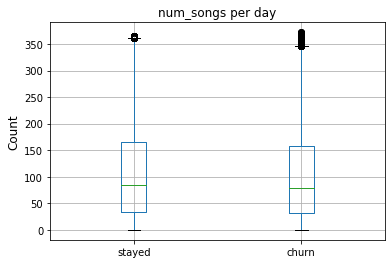

In [71]:
make_boxplot('num_songs')

### Length

In [72]:
# length of songs played in a day
df_valid = df_valid.withColumn("lengths", F.sum("length").over(windowval))

(           count          mean           std  min         25%           50%  \
 stayed  233290.0  27769.156575  23517.139561  0.0  8529.77579  21190.439805   
 churn    44864.0  26370.493882  23030.127657  0.0  7774.64697  19224.560040   
 
                  75%          max  
 stayed  41108.013370  88642.76284  
 churn   38993.637223  89040.98619  ,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca36e51210>)

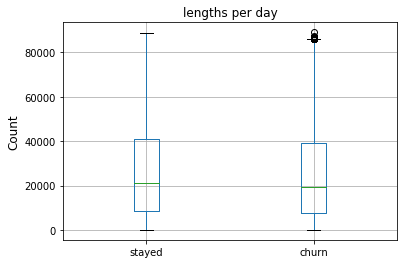

In [73]:
make_boxplot('lengths')

In [74]:
# check song counts
df_valid.select(["userId", 'dt', 'song', 'num_songs', 'lengths',
                 'sessionId']).where(df_valid.userId == "33").show(40)

+------+-------------------+--------------------+---------+------------------+---------+
|userId|                 dt|                song|num_songs|           lengths|sessionId|
+------+-------------------+--------------------+---------+------------------+---------+
|    33|2018-10-01 07:46:24|      Shut Your Eyes|        1|         197.09342|      221|
|    33|2018-10-01 07:49:41|Plumber In Progre...|        2|         697.10276|      221|
|    33|2018-10-01 07:49:42|                null|        2|         697.10276|      221|
|    33|2018-10-01 07:49:45|                null|        2|         697.10276|      221|
|    33|2018-10-01 07:58:01|Chill Out (Things...|        3|         984.24027|      221|
|    33|2018-10-01 08:02:48|              On Top|        4|        1243.13941|      221|
|    33|2018-10-01 08:07:06|Suffragette City ...|        5|        1450.02875|      221|
|    33|2018-10-01 08:10:32|           Fireflies|        6|        1675.20381|      221|
|    33|2018-10-01 08

### Sessions

In [75]:
# number of sessions in a day
df_valid = df_valid.withColumn(
    "num_sessions", F.count("sessionId").over(windowval))

(           count        mean         std  min   25%    50%    75%    max
 stayed  233290.0  133.449441  111.058138  1.0  42.0  103.0  198.0  439.0
 churn    44864.0  128.028731  108.969669  1.0  39.0   96.0  190.0  436.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca36ea56d0>)

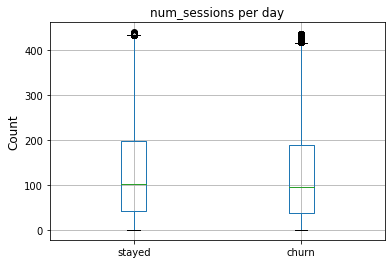

In [76]:
make_boxplot('num_sessions')

### Item in Session

In [77]:
df_valid = df_valid.withColumn(
    "num_session_items", F.sum("itemInSession").over(windowval))

(           count          mean           std  min    25%     50%       75%  \
 stayed  233290.0  17040.730769  33632.793155  0.0  831.0  4656.0  18059.75   
 churn    44864.0  15360.512527  28687.713300  0.0  732.0  3912.0  16138.00   
 
              max  
 stayed  462892.0  
 churn   261652.0  ,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca36f0bad0>)

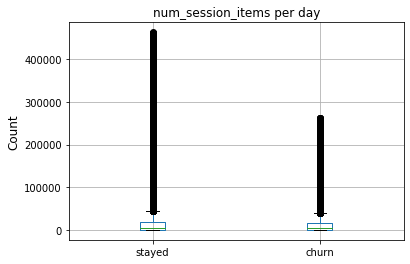

In [78]:
make_boxplot('num_session_items')

### Artist

In [79]:
# number of distinct artists played in a day
df_valid = df_valid.withColumn("num_artists", F.size(
    F.collect_set("artist").over(windowval)))

(           count        mean        std  min   25%   50%    75%    max
 stayed  233290.0  103.620425  84.233414  0.0  34.0  82.0  155.0  331.0
 churn    44864.0   99.120185  83.465901  0.0  31.0  75.0  148.0  332.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca36a71fd0>)

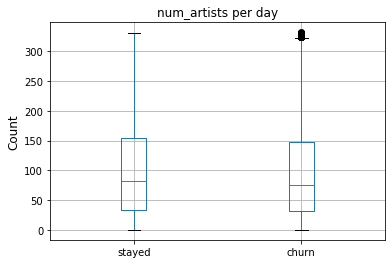

In [80]:
make_boxplot('num_artists')

### Status

In [81]:
df_valid.groupby('status').count().show()

+------+------+
|status| count|
+------+------+
|   307| 23184|
|   404|   252|
|   200|254718|
+------+------+



In [82]:
# number of distinct status in a day
df_valid = df_valid.withColumn("num_status", F.size(
    F.collect_set("status").over(windowval)))

(           count      mean       std  min  25%  50%  75%  max
 stayed  233290.0  2.028664  0.430031  1.0  2.0  2.0  2.0  3.0
 churn    44864.0  2.009451  0.407123  1.0  2.0  2.0  2.0  3.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca371b19d0>)

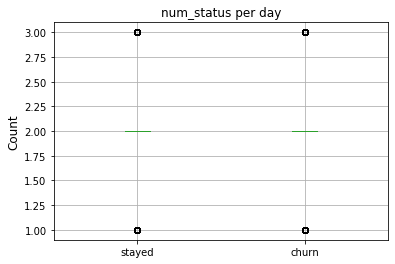

In [83]:
make_boxplot('num_status')

In [84]:
# flag the status 'redirect' and 'not found'
flag_redirect = F.udf(lambda x: 1 if x == 307 else 0, T.IntegerType())
flag_not_found = F.udf(lambda x: 1 if x == 404 else 0, T.IntegerType())

In [85]:
# create redirect and page_not_found columns
df_valid = df_valid.withColumn("redirect", flag_redirect(df_valid['status']))
df_valid = df_valid.withColumn(
    "page_not_found", flag_not_found(df_valid['status']))

In [86]:
df_valid.filter(df_valid['status'] == '307').select(
    F.sum("churn_event")).show()

+----------------+
|sum(churn_event)|
+----------------+
|               0|
+----------------+



In [87]:
df_valid.filter(df_valid['status'] == '200').select(
    F.sum("churn_event")).show()

+----------------+
|sum(churn_event)|
+----------------+
|              52|
+----------------+



### Page

In [88]:
df_valid.groupby('page').count().show(22, False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Thumbs Down              |2546  |
|Home                     |10082 |
|Downgrade                |2055  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Save Settings            |310   |
|Cancellation Confirmation|52    |
|About                    |495   |
|Settings                 |1514  |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Help                     |1454  |
|Upgrade                  |499   |
|Error                    |252   |
|Submit Upgrade           |159   |
+-------------------------+------+



In [89]:
# create aggregate features from the column 'page'

pages = ['Thumbs Up', 'Home', 'Roll Advert',
         'Logout', 'Add to Playlist', 'Add Friend']

for page in pages:
    flag_page = F.udf(lambda x: 1 if x == page else 0, T.IntegerType())
    df_valid = df_valid.withColumn('flag', flag_page('page'))
    df_valid = df_valid.withColumn(
        'num_' + page, F.sum('flag').over(windowval)).drop('flag')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  6.013112  5.820115  0.0  1.0  4.0  9.0  38.0
 churn    44864.0  5.338802  5.187177  0.0  1.0  4.0  8.0  30.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca3634f050>)

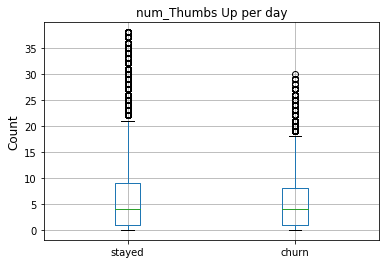

In [90]:
make_boxplot('num_Thumbs Up')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  4.506485  3.661779  0.0  2.0  4.0  7.0  22.0
 churn    44864.0  4.512750  3.883828  0.0  2.0  4.0  6.0  20.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca383d2290>)

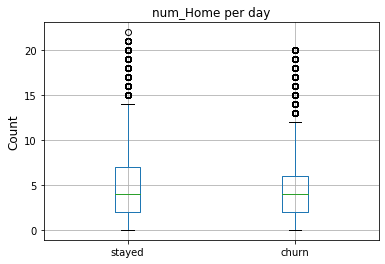

In [91]:
make_boxplot('num_Home')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  0.956385  2.436229  0.0  0.0  0.0  1.0  38.0
 churn    44864.0  1.591789  3.476550  0.0  0.0  0.0  1.0  27.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca36c9b9d0>)

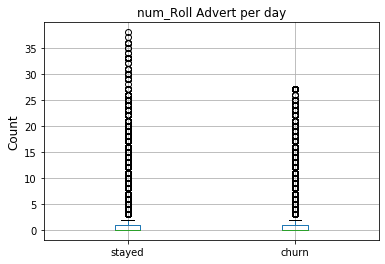

In [92]:
make_boxplot('num_Roll Advert')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  1.309340  1.527900  0.0  0.0  1.0  2.0  10.0
 churn    44864.0  1.351863  1.555943  0.0  0.0  1.0  2.0   9.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca37e4e750>)

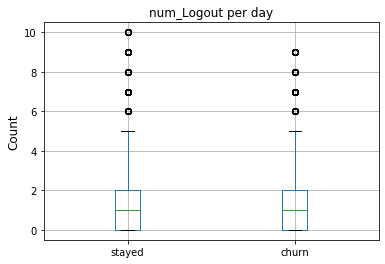

In [93]:
make_boxplot('num_Logout')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  3.135557  3.176421  0.0  1.0  2.0  5.0  19.0
 churn    44864.0  3.046451  3.223029  0.0  1.0  2.0  4.0  17.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca3b3c9b10>)

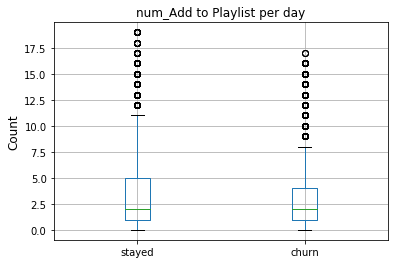

In [94]:
make_boxplot('num_Add to Playlist')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  2.028672  2.535615  0.0  0.0  1.0  3.0  21.0
 churn    44864.0  1.692961  2.089752  0.0  0.0  1.0  3.0  11.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca3b3d3c90>)

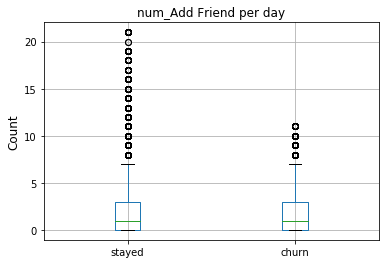

In [95]:
make_boxplot('num_Add Friend')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [96]:
def clean_data(df):
    "Return valid data by dropping missing values and empty strings for userId and sessionId. "
    df_clean = df.dropna(how='any', subset=['userId', 'sessionId']).filter(
        df['userId'] != '').na.fill(0, subset=['length'])

    return df_clean

In [97]:
def is_churn(df):
    "Return the dataframe with labels for churn users"
    flag_churn_event = F.udf(lambda x: 1 if (
        x == 'Cancellation Confirmation') else 0, T.IntegerType())
    df_new = df.withColumn(
        'churn_event', flag_churn_event('page'))
    df_new = df_new.withColumn('label', F.max(
        'churn_event').over(Window.partitionBy('userId')))

    return df_new

In [98]:
def registration_days(df):
    "Return the number of days since registration"

    df_new = df.withColumn('registration date', (F.col(
    'registration')/1000).cast(T.TimestampType()))

    df_new = df_new.withColumn(
    'date', (F.col('ts')/1000).cast(T.TimestampType()))

    df_new = df_new.withColumn('days_since_registration', (F.datediff(
    'date', 'registration date'))).drop('date', 'registration date')

    return df_new

In [99]:
# time window to find aggregate values per day
def days(x):
    "Return seconds for the input x days."
    return x * 86400

In [100]:
windowval = (
    Window.partitionBy('userId')
    .orderBy(F.col('ts')/1000)
    .rangeBetween(-days(1), 0)
)

In [101]:
def aggregate_features_1(df):
    "Return aggregate features over the time window for columns\
    'song', 'length', 'sessionId', 'itemInSession', and 'artist'"

    df_new = df.withColumn('num_songs', F.count(
        'song').over(windowval)).drop('song')

    df_new = df_new.withColumn('lengths', F.sum(
        'length').over(windowval)).drop('length')

    df_new = df_new.withColumn('num_sessions', F.count(
        'sessionId').over(windowval)).drop('sessionId')

    df_new = df_new.withColumn('num_session_items', F.sum(
        'itemInSession').over(windowval)).drop('itemInSession')

    df_new = df_new.withColumn('num_artists', F.size(
        F.collect_set('artist').over(windowval))).drop('artist')

    return df_new

In [102]:
# create aggregate features from the column 'page'
pages = ['Thumps Up', 'Roll Advert', 'Add Friend']

def aggregate_features_2(df):
    "Return selected aggregate features from page."
    df_new = df
    for page in pages:
        flag_page = F.udf(lambda x: 1 if x == page else 0, T.IntegerType())
        df_new = df_new.withColumn('flag', flag_page('page'))
        df_new = df_new.withColumn(
            'num_' + page, F.sum('flag').over(windowval)).drop('flag')
    
    return df_new

In [103]:
def retrive_state(df):
    "Return dataframe with states retrived from locations"
    df_new = df
    get_state = F.udf(lambda x: x[-2:])
    df_new = df_new.withColumn("state", get_state(
        df_new['location'])).drop('location')
    
    return df_new    

In [104]:
drop_list = ['userId', 'auth', 'firstName', 'page', 'registration',
                   'firstName', 'lastName', 'method', 'userAgent']


def remove_features(df, drop_list):
    "Remove unnecessary feature columns"
    df_new = df.drop(*drop_list)

    return df_new

In [105]:
def preprocess_data(df):
    
    df_clean = clean_data(df)
    df_churn = is_churn(df_clean)
    df_reg_days = registration_days(df_churn)
    df_aggregate_1 = aggregate_features_1(df_reg_days)
    df_aggregate_2 = aggregate_features_2(df_aggregate_1)
    df_state = retrive_state(df_aggregate_2)
    df_processed_1 = remove_features(df_state, drop_list)
    
    return df_processed_1
    

In [106]:
df_processed = preprocess_data(df)

In [112]:
cat_columns = ['gender', 'level', 'status', 'state']

stages = []

for column in cat_columns:
    indexer = StringIndexer(inputCol=column, outputCol=column+'_index')
    encoder = OneHotEncoderEstimator(
        inputCols=[indexer.getOutputCol()], outputCols=[column + '_vect'])

    stages += [indexer, encoder]

In [ ]:
num_columns = ['ts',
               'churn_event',
               'days_since_registration',
               'num_songs',
               'lengths',
               'num_sessions',
               'num_session_items',
               'num_artists',
               'num_Thumps Up',
               'num_Roll Advert',
               'num_Add Friend',
               ]

vect_assembler_inputs = [c + '_vect' for c in cat_columns] + num_columns
assembler = VectorAssembler(
    inputCols=vect_assembler_inputs, outputCol="features")
stages += [assembler]

In [ ]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

stages += [scaler]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [113]:
# split the full dataset into train, test, and validation sets
train, test, val = df_processed.randomSplit([0.8, 0.1, 0.1], seed=42)
# display shape of datasets
print('df_processed shape: {}, {}'.format(df_processed.count(), len(df_processed.columns)))
print('train shape: {}, {}'.format(train.count(), len(train.columns)))
print('test shape: {}, {}'.format(test.count(),len(test.columns)))
print('validation shape: {}, {}'.format(val.count(), len(val.columns)))

df_processed shape: 278154, 16
train shape: 222612, 16
test shape: 27645, 16
validation shape: 27897, 16


In [114]:
pipeline = Pipeline().setStages(stages)
pipeline_model = pipeline.fit(train)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.